Random forest uses multiple decision trees and is preferred for datasets having a good mix of categorical and numerical features

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')


Train Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39211 entries, 0 to 39210
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   last contact date  39211 non-null  object
 1   age                39211 non-null  int64 
 2   job                38982 non-null  object
 3   marital            39211 non-null  object
 4   education          37744 non-null  object
 5   default            39211 non-null  object
 6   balance            39211 non-null  int64 
 7   housing            39211 non-null  object
 8   loan               39211 non-null  object
 9   contact            28875 non-null  object
 10  duration           39211 non-null  int64 
 11  campaign           39211 non-null  int64 
 12  pdays              39211 non-null  int64 
 13  previous           39211 non-null  int64 
 14  poutcome           9760 non-null   object
 15  target             39211 non-null  object
dtypes: int64(6), object(10)

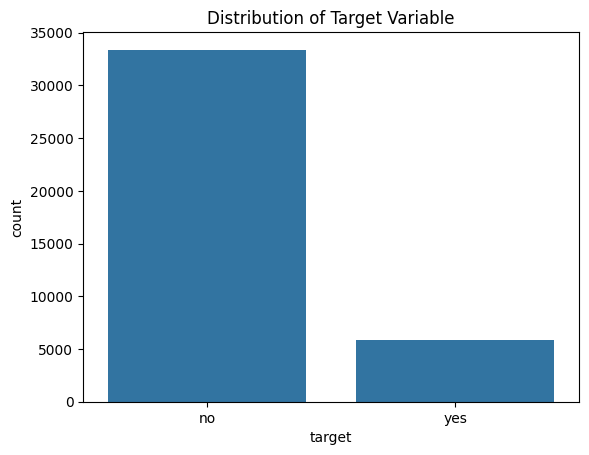

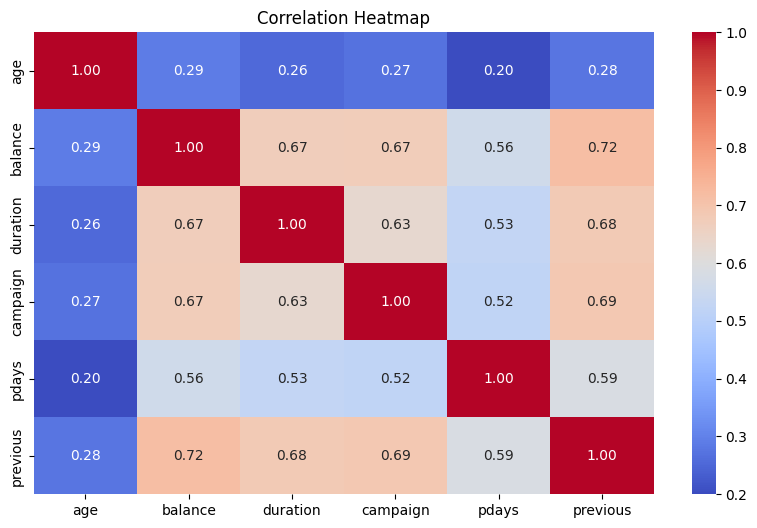

In [ ]:
#EDA and insights

print("Train Data Info:")
print(train.info())
print("\nTest Data Info:")
print(test.info())

#checking missing values
print("\nMissing Values in Train:")
print(train.isnull().sum())
print("\nMissing Values in Test:")
print(test.isnull().sum())

# Plot missing values heatmap to see the inconsistency with distribution of missing values
sns.heatmap(train.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values in Train Dataset")
plt.show()

# target variable countplot
sns.countplot(data=train, x='target')
plt.title("Distribution of Target Variable")
plt.show()

# Selecting only numerical columns from the train dataset
numerical_columns = train.select_dtypes(include=["number"])

# Check if numerical_columns is not empty
if not numerical_columns.empty:
    # Correlation heatmap for numerical features
    plt.figure(figsize=(10, 6))
    sns.heatmap(numerical_columns.corr(), annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Heatmap")
    plt.show()
else:
    print("No numerical columns found for correlation heatmap.")

In [2]:
#Feature handling

# Fill missing values for numerical columns using median

train.fillna(train.median(numeric_only=True), inplace=True)
test.fillna(test.median(numeric_only=True), inplace=True)

# Fill missing values for categorical columns using mode

for col in train.select_dtypes(include='object').columns:
    train[col].fillna(train[col].mode()[0], inplace=True)

for col in test.select_dtypes(include='object').columns:
    test[col].fillna(test[col].mode()[0], inplace=True)

# Encode target variable as either 0 or 1
y_train = train['target'].apply(lambda x: 1 if x == 'yes' else 0)
X_train = train.drop(['target'], axis=1)

# Handle categorical features using Label Encoding

label_encoders = {}    # initiate dictionary to store le objects
for col in X_train.select_dtypes(include='object').columns:       #select categorical features
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])     # encodes each categorical columns to numeric labels
    if col in test.columns:
        test[col] = test[col].map(lambda s: le.classes_.tolist().index(s) if s in le.classes_ else -1)
    label_encoders[col] = le


/tmp/ipykernel_2263/4140822295.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train[col].fillna(train[col].mode()[0], inplace=True)
/tmp/ipykernel_2263/4140822295.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)

In [ ]:
# Split train data into train and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Train the Random Forest Classifier
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    class_weight='balanced'   # to provide more weight to minority classes, as dataset is imbalanced
)
rf_model.fit(X_train_split, y_train_split)

RandomForestClassifier(class_weight='balanced', max_depth=10, random_state=42)

In [ ]:
#Training the model

# Predict on validation set
y_val_pred = rf_model.predict(X_val_split)

# Calculate F1 score on validation set
print(f'Validation F1 Score (macro): {f1_score(y_val_split, y_val_pred, average="macro")}')
print("\nClassification Report on Validation Data:")
print(classification_report(y_val_split, y_val_pred))

# Prepare test dataset
X_test = test.copy()
y_test_pred = rf_model.predict(X_test)

# Prepare submission file
submission = pd.DataFrame({'id': range(len(y_test_pred)), 'target': ['yes' if y == 1 else 'no' for y in y_test_pred]})
submission.to_csv('submission_rf.csv', index=False)


Validation F1 Score (macro): 0.746610412882978

Classification Report on Validation Data:
              precision    recall  f1-score   support

           0       0.96      0.84      0.90      6645
           1       0.47      0.81      0.60      1198

    accuracy                           0.83      7843
   macro avg       0.72      0.82      0.75      7843
weighted avg       0.89      0.83      0.85      7843



In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from skopt import BayesSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Fill missing values
train.fillna(train.median(numeric_only=True), inplace=True)
test.fillna(test.median(numeric_only=True), inplace=True)

for col in train.select_dtypes(include='object').columns:
    train[col].fillna(train[col].mode()[0], inplace=True)
    if col in test.columns:
        test[col].fillna(test[col].mode()[0], inplace=True)

# Encode target and categorical features
y_train = train['target'].apply(lambda x: 1 if x == 'yes' else 0)
X_train = train.drop(['target'], axis=1)

label_encoders = {}
for col in X_train.select_dtypes(include='object').columns:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    if col in test.columns:
        test[col] = test[col].map(lambda s: le.classes_.tolist().index(s) if s in le.classes_ else -1)
    label_encoders[col] = le

# Split train data
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Hyperparameter Tuning with BayesSearchCV
from skopt.space import Integer, Real

param_space_rf = {
    'n_estimators': Integer(50, 300),
    'max_depth': Integer(3, 15),
    'min_samples_split': Integer(2, 20),
    'min_samples_leaf': Integer(1, 10),
    'max_features': Real(0.5, 1.0, prior='uniform')
}

rf = RandomForestClassifier(random_state=42, class_weight='balanced')
bayes_search_rf = BayesSearchCV(
    estimator=rf,
    search_spaces=param_space_rf,
    scoring='f1_macro',
    cv=3,
    n_iter=30,  # Number of iterations
    random_state=42,
    verbose=1
)

# Train the model with BayesSearchCV
bayes_search_rf.fit(X_train_split, y_train_split)

# Best Random Forest Model
best_rf_model = bayes_search_rf.best_estimator_
print(f"Best Parameters for Random Forest: {bayes_search_rf.best_params_}")

# Pipeline
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', best_rf_model)
])

rf_pipeline.fit(X_train_split, y_train_split)

# Predict and Evaluate
y_val_pred = rf_pipeline.predict(X_val_split)

# Validation Metrics
print("\nRandom Forest Classification Report on Validation Set:")
print(classification_report(y_val_split, y_val_pred))

# Confusion Matrix
cm_rf = confusion_matrix(y_val_split, y_val_pred)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['No', 'Yes'])
disp_rf.plot(cmap='Greens', values_format='d')
plt.title("Confusion Matrix for Random Forest")
plt.show()

# Predict on Test Data
y_test_pred = rf_pipeline.predict(test)
submission = pd.DataFrame({'id': range(len(y_test_pred)), 'target': ['yes' if y == 1 else 'no' for y in y_test_pred]})
submission.to_csv('submission_rf.csv', index=False)


/tmp/ipykernel_6644/2934101411.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train[col].fillna(train[col].mode()[0], inplace=True)
/tmp/ipykernel_6644/2934101411.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


KeyboardInterrupt: 